In [455]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px

import plotly.graph_objects as go

#### Cargar data.

In [456]:
# Cargar data
# Path to the file
path_file_train = "./datasets_procesados/train.csv"
path_file_test = "./datasets_procesados/test.csv"

df_train = pd.read_csv(path_file_train)
df_test = pd.read_csv(path_file_test)


## Modelo

Nota: Función de regresión no lineal
$h(X) = X*W^t$

In [457]:
def h(X, W):
    return np.dot(X, W)

## Loss function

Con regularización _Ridge
$\mathcal{L} =  \frac{||Y - XW^t||^2_2}{2n} + \lambda||W||^2_2$

Con regularización _Lasso
$\mathcal{L} =  \frac{||Y - XW^t||_1}{2n} + \lambda||W||_1$

In [458]:
def Error(X, W, Y,lam, reg = 2):
    # Calcula las predicciones del modelo
    diff = h(X, W)
    # Calcula el error cuadrático medio
    # L2
    if (reg == 2):
        error = (np.linalg.norm((Y - diff)) ** 2) / (2 * len(Y)) + (lam * (np.linalg.norm(W)**2))
    # L1
    elif (reg == 1):
        error = (np.linalg.norm((Y - diff)) ** 2) / (2 * len(Y)) + (lam * (np.linalg.norm(W, ord=1)))

    #Sin regularización
    else:
        error = (np.linalg.norm((Y - diff)) ** 2) / (2 * len(Y))
    return error

## Cálculo de derivadas


$dw_j = \frac{\sum_{i=0}^m(y_i - h(x_i))(-x_{i}^j)}{n} + 2\lambda w_j$

In [459]:
def derivada(X, W, Y, lam):
    diff = h(X, W) - Y
    dw =  np.matmul(Y - diff,-X)/len(Y) + 2*lam*W
    return dw

## Actualiación de parámetros

*   Elemento de la lista
*   Elemento de la lista



Recuerde: $\frac{\partial L}{\partial w}$ representa un vector con todas las derivadas de la función de pérdida con rescto a W.

$W  = W - \alpha*\frac{\partial L}{\partial W} $



In [460]:
def update(W, dW, alpha):
    return W - (alpha * dW)

### Training

In [461]:
def train(X, Y, epochs, alfa, lam, reg =2):
    np.random.seed(2001)
    W = np.array([np.random.rand() for i in range(X.shape[1])])
    L = Error(X, W, Y, lam)
    loss = []
    for i in range(epochs):
        dW = derivada(X, W, Y, lam)
        W = update(W, dW, alfa)
        L = Error(X, W, Y, lam, reg)
        loss.append(L)
        if i % 10000 == 0:
            print(L)
    return W, loss

### Normalización de data

In [462]:
def normalizar(x):
    max = x.max()
    min = x.min()
    return (x - min) / (max - min)


def desnormalizar(x, x_norm):
    max = x.max()
    min = x.min()
    return x_norm * (max - min) + min

In [463]:
# Convertir a numpy y normalizar  df_train y df_test
# Convertir df_train a una matriz numpy
train_np = df_train.to_numpy()
# Extraer las características (X) y las etiquetas (Y)
X = train_np[:, :-1]  
Y = train_np[:, -1]

X_norm = normalizar(X)
Y_norm = normalizar(Y)

### Randomly splitting data for training and testing
*   Training $70$\%
*   Training $30$\%

In [464]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y_norm, random_state=104, train_size=0.7,test_size=0.30, shuffle=True)

Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

### Testing

In [465]:
def Testing(x_test, y_test, w):
    n = len(y_test)
    y_pred = []
    matches = 0
    for i in range(n):
        pred = S(x_test[i], w)
        y_pred.append(pred)
        if round(pred) == y_test[i]:
            matches += 1
    print("Number of correct data: ", matches, " out of ", n)
    print("Accuracy: ", matches / n)


## Training model

In [466]:
def get_matriz(X, p):
    m, n = X.shape
    matriz = np.ones((m, 1))
    for i in range(n):
        arreglo = X[:, i : i + 1]
        if arreglo.dtype == "object":
            arreglo = arreglo.astype(
                float
            )  # Convertir a tipo float si los datos son cadenas
        matriz_potencias = np.power(arreglo, np.arange(1, p + 1))
        matriz = np.concatenate((matriz, matriz_potencias), axis=1)
    return matriz


def plot_prediccion_vs_real(ID, y_pred, y_real):
    sns.scatterplot(x=ID, y=y_pred, color="red", label="Predicción")
    sns.scatterplot(x=ID, y=y_real, color="blue", label="Real")
    plt.xlabel("ID")
    plt.ylabel("Valor")
    plt.title("Predicción vs Real")
    plt.legend()
    plt.show()


def entrenar_con_70_30(epochs , alpha , lam, grado, X_train, Y_train, X_test, Y_test=None, reg = 2):
    ## Definir X
    X_train = get_matriz(X_train, grado)
    X_test = get_matriz(X_test, grado)

    W,L  = train(X_train, Y_train, epochs, alpha, lam, reg)
    # Plotting the Loss Function vs Epochs
    epochs_list = [i for i in range(epochs)]
    plt.plot(epochs_list, L)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.show()

    # Testing
    y_pred = h(X_test, W)
    ID = range(1, len(y_pred) + 1)  # Generar IDs incrementales
    plot_prediccion_vs_real([i for i in range(len(Y_test))], y_pred, Y_test)


    return W

## Predecir valores de test

In [467]:
# ## Predecir la data de test:
# X_TEST = df_test.to_numpy()  # Aqui se predecira para entregar
# X_TEST = normalizar(X_TEST)
# X_TEST = get_matriz(X_TEST,grado)
# Y_predecido = h(X_TEST,W)
# Y_predecido = desnormalizar(Y, Y_predecido)

# # Convertir el arreglo a un DataFrame de Pandas
# df_prediccion = pd.DataFrame({"MTO_PIA": Y_predecido})

# # Crear una serie de Pandas con IDs incrementales
# ids = pd.Series(range(1, len(df_prediccion) + 1), name="ID")

# # Insertar la serie de IDs en el DataFrame antes de la columna 'MTO_PIA'
# df_prediccion.insert(0, "ID", ids)

# df_prediccion.to_csv("./data_predicion/Prediccion.csv", index=False)

## Experimentación

In [468]:
def exp(epochs, alpha, lam, grado, X_train, Y_train ,X_test, Y_test, X_TEST, Y, reg, name_csv):
    W = entrenar_con_70_30(epochs, alpha, lam, grado, X_train, Y_train, X_test, Y_test, reg)
    # W = entrenar_con_70_30(epochs, alpha, lam, grado, X_norm, Y_norm, X_TEST)

    ## Predecir la data de test:
    X_TEST = df_test.to_numpy()  # Aqui se predecira para entregar
    X_TEST = normalizar(X_TEST)
    X_TEST = get_matriz(X_TEST, grado)
    Y_predecido = h(X_TEST, W)
    Y_predecido = desnormalizar(Y, Y_predecido)

    # Convertir el arreglo a un DataFrame de Pandas
    df_prediccion = pd.DataFrame({"MTO_PIA": Y_predecido})

    # Crear una serie de Pandas con IDs incrementales
    ids = pd.Series(range(1, len(df_prediccion) + 1), name="ID")

    # Insertar la serie de IDs en el DataFrame antes de la columna 'MTO_PIA'
    df_prediccion.insert(0, "ID", ids)

    df_prediccion.to_csv(name_csv, index=False)

In [472]:
# Hyperparameters
epochs = 60000
alpha = 0.009
lam = 0.1
grado = 5

### Regresión no lineal con regularización L2

CON REGULARIZACIÓN L2
2.812434675911813
0.0025744696690422125
0.0025744696696055323
0.0025744696696055323
0.0025744696696055323
0.0025744696696055323


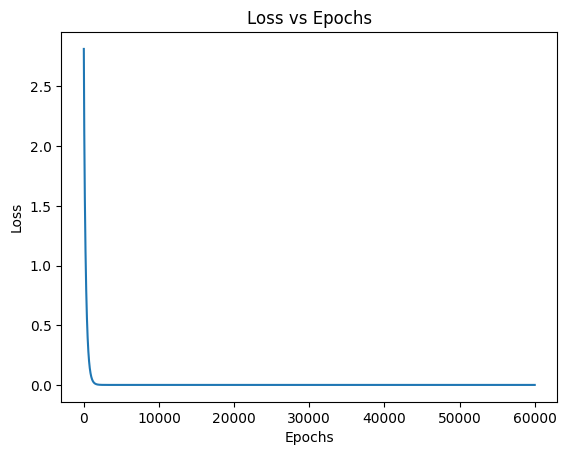

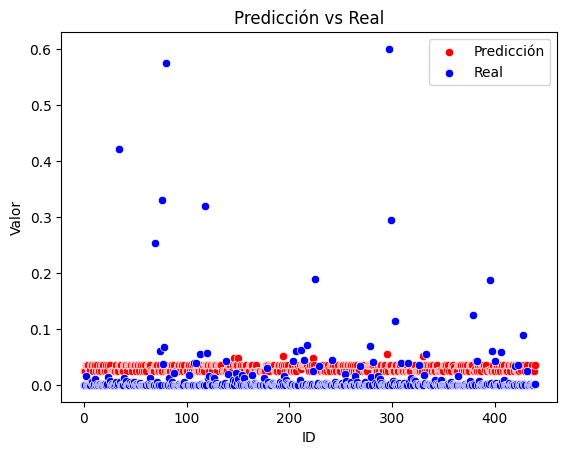

In [473]:
print("CON REGULARIZACIÓN L2")
reg= 2
name_csv = "./data_predicion/Prediccion_l2.csv"
exp(epochs, alpha, lam, grado, X_train, Y_train ,X_test, Y_test, X_TEST, Y, reg, name_csv)

### Regresión no lineal con regularización L1

CON REGULARIZACIÓN L1
4.246496401883958
0.00798769173092843
0.007987652395229698
0.007987652395229443
0.007987652395229443
0.007987652395229443


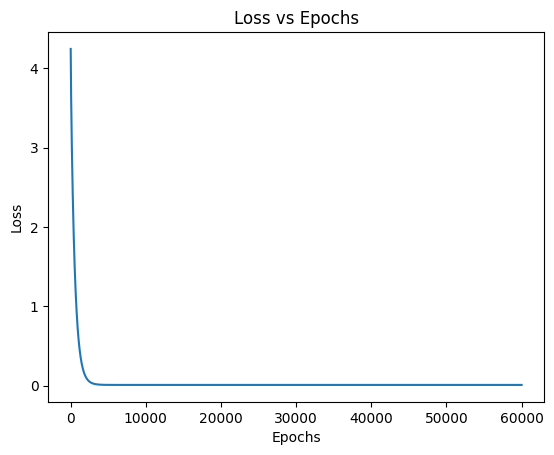

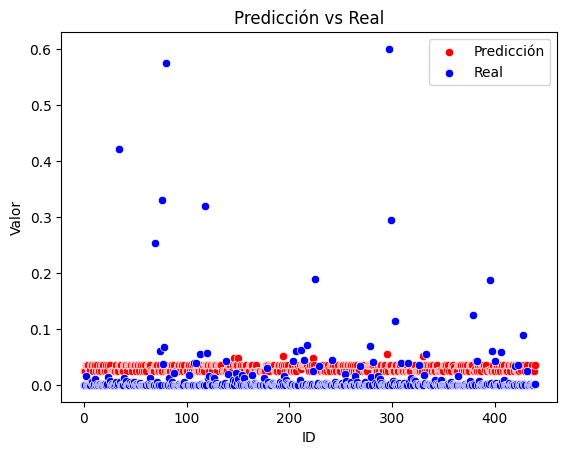

In [474]:
print("CON REGULARIZACIÓN L1")
reg= 1
name_csv = "./data_predicion/Prediccion_l1.csv"
exp(epochs, alpha, lam, grado, X_train, Y_train ,X_test, Y_test, X_TEST, Y, reg, name_csv)

### Regresión no lineal sin regularización

CON SIN REGULARIZACIÓN 
0.2669106217534634
0.0024842870318595284
0.002484287031334123
0.002484287031334123
0.002484287031334123
0.002484287031334123


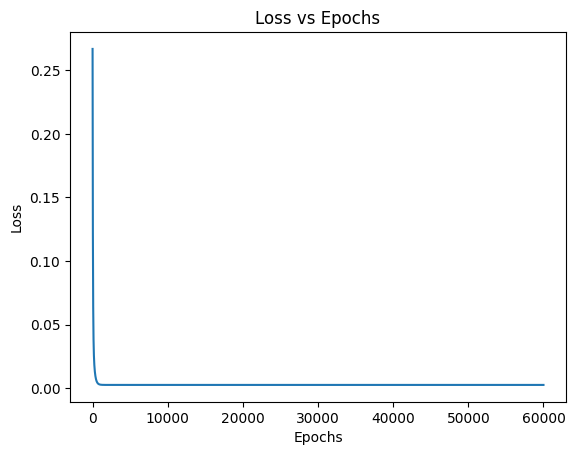

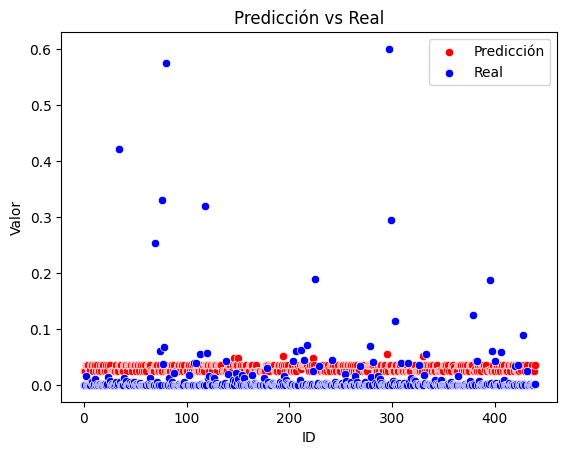

In [475]:
print("CON SIN REGULARIZACIÓN ")
reg= 0
name_csv = "./data_predicion/Prediccion_sinl.csv"
exp(epochs, alpha, lam, grado, X_train, Y_train ,X_test, Y_test, X_TEST, Y, reg, name_csv)